# Project：Fruit Recognition

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt # for plotting

## Fruit 360 Data Processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# location on Google Drive
master_path = '/content/drive/My Drive/Colab Notebooks/fruit360_v3/656/'

# Transform Settings - Do not use RandomResizedCrop
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomRotation(90),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=3, fill=0), 
                                transforms.ToTensor()])

dataset = torchvision.datasets.ImageFolder(master_path, transform=transform)
train_size = int(0.6 * (len(dataset)))
val_size = int(0.25 * (len(dataset)))
test_size = len(dataset) - train_size - val_size
print (train_size, val_size, test_size)
# assumes three folders with 60% training, 25% validation and 15% testing samples
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
print (len(train_dataset), len(val_dataset), len(test_dataset))
#test_dataset = torchvision.datasets.ImageFolder(master_path + 'Test', transform=transform)

35055 14606 8764
35055 14606 8764


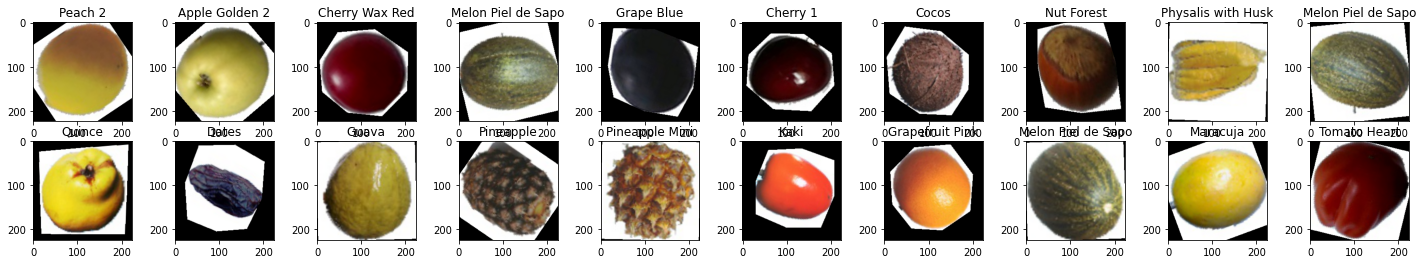

In [ ]:
# Prepare Dataloader
batch_size = 27
num_workers = 1

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)


# Visualize some sample data
classes = ['Apple Braeburn', 'Apple Golden 2', 'Apple Granny Smith', 
            'Apple Red 1', 'Apple Red 2', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 
            'Apricot', 'Avocado ripe', 'Banana', 'Banana Red', 'Cactus fruit', 
            'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 
            'Cherry Wax Red', 'Cherry Wax Yellow', 'Clementine', 'Cocos', 'Dates', 'Fig', 
            'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 
            'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Huckleberry', 'Kaki', 'Kumquats', 
            'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Maracuja', 'Melon Piel de Sapo', 
            'Mulberry', 'Nectarine', 'Nut Forest', 'Nut Pecan', 'Papaya', 'Passion Fruit', 'Peach', 
            'Peach 2', 'Peach Flat', 'Pear', 'Pear 2', 'Pear Abate', 'Pear Forelle', 
            'Pear Monster', 'Pear Red', 'Pear Stone', 'Pear Williams', 'Pepino', 'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 
            'Physalis', 'Physalis with Husk', 'Pineapple', 'Pineapple Mini', 'Pitahaya Red', 'Plum 3', 'Pomegranate', 
            'Quince', 'Rambutan', 'Raspberry', 
            'Redcurrant', 'Strawberry', 'Strawberry Wedge', 'Tamarillo', 'Tangelo', 'Tomato 1', 'Tomato 2', 'Tomato 3', 
            'Tomato Cherry Red', 'Tomato Heart', 'Walnut']

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1)
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Fruit 360 Transfer Learning

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

In [ ]:
import os
# location on Google Drive
master_path = '/content/drive/My Drive/Colab Notebooks/fruit360_v3/Alex_features'
classes = ['Apple Braeburn', 'Apple Golden 2', 'Apple Granny Smith', 
            'Apple Red 1', 'Apple Red 2', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 
            'Apricot', 'Avocado ripe', 'Banana', 'Banana Red', 'Cactus fruit', 
            'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 
            'Cherry Wax Red', 'Cherry Wax Yellow', 'Clementine', 'Cocos', 'Dates', 'Fig', 
            'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 
            'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Huckleberry', 'Kaki', 'Kumquats', 
            'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Maracuja', 'Melon Piel de Sapo', 
            'Mulberry', 'Nectarine', 'Nut Forest', 'Nut Pecan', 'Papaya', 'Passion Fruit', 'Peach', 
            'Peach 2', 'Peach Flat', 'Pear', 'Pear 2', 'Pear Abate', 'Pear Forelle', 
            'Pear Monster', 'Pear Red', 'Pear Stone', 'Pear Williams', 'Pepino', 'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 
            'Physalis', 'Physalis with Husk', 'Pineapple', 'Pineapple Mini', 'Pitahaya Red', 'Plum 3', 'Pomegranate', 
            'Quince', 'Rambutan', 'Raspberry', 
            'Redcurrant', 'Strawberry', 'Strawberry Wedge', 'Tamarillo', 'Tangelo', 'Tomato 1', 'Tomato 2', 'Tomato 3', 
            'Tomato Cherry Red', 'Tomato Heart', 'Walnut']

batch_size = 1
num_workers = 1

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# save features to folder as tensors
n = 0
print("Start saving for train")
for img, label in train_loader:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())
  folder_name = master_path + '/train/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1

print("Finish saving for train")

n = 0
print("Start saving for val")
for img, label in val_loader:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = master_path + '/validation/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1

print("Finish saving for val")

n = 0
print("Start saving for test")
for img, label in test_loader:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = master_path + '/test/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1
print("Finish saving for test")

Start saving for train
Finish saving for train
Start saving for val
Finish saving for val
Start saving for test
Finish saving for test


In [ ]:
# Load Tensor Files (features) from folder
master_path = '/content/drive/My Drive/Colab Notebooks/fruit360_v3/Alex_features'
#load features
# location on Google Drive
train_feature_dataset = torchvision.datasets.DatasetFolder(master_path + '/' + 'train', loader=torch.load, extensions=('.tensor'))
val_feature_dataset = torchvision.datasets.DatasetFolder(master_path + '/' + 'validation', loader=torch.load, extensions=('.tensor'))
test_feature_dataset = torchvision.datasets.DatasetFolder(master_path + '/' + 'test', loader=torch.load, extensions=('.tensor'))

print (len(train_feature_dataset))
print (len(val_feature_dataset))
print (len(test_feature_dataset))
# Prepare Dataloader
batch_size = 32
num_workers = 1

#train feature loader
train_feature_loader = torch.utils.data.DataLoader(train_feature_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# Verification Step - obtain one batch of features
dataiter = iter(train_feature_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)

#validation feature loader
val_feature_loader = torch.utils.data.DataLoader(val_feature_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# Verification Step - obtain one batch of features
dataiter = iter(val_feature_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)

#test feature loader
test_feature_loader = torch.utils.data.DataLoader(test_feature_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# Verification Step - obtain one batch of features
dataiter = iter(test_feature_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)

35055
14606
8764
torch.Size([32, 256, 6, 6])
torch.Size([32])
torch.Size([32, 256, 6, 6])
torch.Size([32])
torch.Size([32, 256, 6, 6])
torch.Size([32])


In [ ]:
torch.manual_seed(1) # set the random seed
class CNN_feedALEX(nn.Module):
      def __init__(self):
          self.name = "CNN_feedALEX_89"
          super(CNN_feedALEX, self).__init__()
          self.conv1 = nn.Conv2d(256, 128, 2) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(5 * 5 * 128, 256)
          self.fc2 = nn.Linear(256, 89)
      def forward(self, x):
          x = F.relu(self.conv1(x))
          x = x.view(-1, 5 * 5 * 128)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

In [ ]:
torch.manual_seed(1) # set the random seed
class CNN_feedALEX_2(nn.Module):
      def __init__(self):
          self.name = "CNN_feedALEX_2_89"
          super(CNN_feedALEX_2, self).__init__()
          self.fc1 = nn.Linear(6 * 6 * 256, 256)
          self.fc2 = nn.Linear(256, 89)
      def forward(self, x):
          x = x.view(-1, 6 * 6 * 256)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

In [ ]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    n = 0
    for imgs, labels in data_loader:
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
        n += 1
        #if n % 10 == 0: 
        print (n, "accuracy")
    return correct / total

In [ ]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    tune_loss = np.loadtxt("{}_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Training Loss")
    plt.plot(range(1,n+1), tune_loss, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def train_alex(model, train_dataset, val_dataset, batch_size=27, num_epochs=1, learn_rate = 0.001):
    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss() #We use CrossEntropyLoss as this is a classification problem, and more than 2 classes
    optimizer = optim.Adam(model.parameters(), lr=learn_rate) #Adam optimizer has lower training cost than others such as SGD

    train_acc, val_acc, tune_loss = [], [], []
    num_workers = 1
    train_feature_loader = torch.utils.data.DataLoader(train_feature_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
    val_feature_loader = torch.utils.data.DataLoader(val_feature_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
    # training
    print ("Training Started...")
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_feature_loader):
          if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
            if n == 5: 
              print ("CUDA applied")
          out = model(imgs)             # forward pass
          loss = criterion(out, labels) # compute the total loss
          loss.backward()               # backward pass (compute parameter updates)
          optimizer.step()              # make the updates for each parameter
          optimizer.zero_grad()         # a clean up step for PyTorch
          n += 1
          if epoch == 0 and n % 10 == 0:
            print (n)
          #if epoch == 0 and n % 150 == 0:
            #print ("150 iters done")
          #elif n > 150:
          #print(n)
        # track accuracy
        if epoch == 0:
          print ("Start getting train accuracy")
        train_acc.append(get_accuracy(model, train_feature_loader))
        if epoch == 0:
          print ("Start getting val accuracy")
        val_acc.append(get_accuracy(model, val_feature_loader))
        if epoch == 0:
          print ("Start getting loss")
        tune_loss.append(float(loss)/batch_size)
        print(epoch, train_acc[-1], val_acc[-1], tune_loss[-1])
        # Save the current model (checkpoint) to a file
        model_path  = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learn_rate, epoch)
        torch.save(model.state_dict(), model_path)
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_loss.csv".format(model_path), tune_loss)

CUDA is not available.  Training on CPU ...
Training Started...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
Start getting train accuracy
Start getting val accuracy
Start getting loss
0 0.4521466267294252 0.43899767218951113 0.01584480330348015
1 0.6090429325345885 0.5911953991510338 0.010757154785096645
2 0.624390243902439 0.6022867314802136 0.011452456936240196
3 0.6929396662387677 0.6628098041900589 0.008568885736167431
4 0.7242333475966338 0.6853347939203067 0.007497797720134258
5 0.732135216089003 0.6899219498836094 0.0065207635052502155
6 0.6965910711738696 0.6645214295495002 0.0073165870271623135
7 0.714819569248324 0.676982062166233 0.006548614706844091
8 0.7545000713165027 0.7061481582911132 0.007502440828830004
9 0.7447725003565825 0.695330686019444 0.006585752125829458
10 0.7571815718157181 0.7042996029029166 0.00838423427194357
11 0.7509057195835116 0.7021087224428317 0.006483896169811487
12 0.7936670945656825 0.73524578

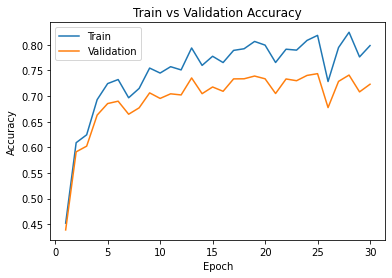

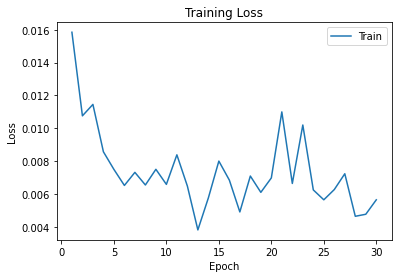

In [ ]:
use_cuda = True

model_ALEX = CNN_feedALEX()

if use_cuda and torch.cuda.is_available():
  model_ALEX.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_alex(model_ALEX, train_feature_dataset, val_feature_dataset, batch_size=128, num_epochs=30, learn_rate=0.01)
model_path = "model_CNN_feedALEX_89_bs128_lr0.01_epoch29"
plot_training_curve(model_path)

In [ ]:
test_feature_loader = torch.utils.data.DataLoader(test_feature_dataset, batch_size=128, 
                                           num_workers=1, shuffle=True)
print("Loader ready")
test_accu = get_accuracy(model_ALEX, test_feature_loader)
print("Test accuracy is", test_accu)

CUDA is not available.  Training on CPU ...
Training Started...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
Start getting train accuracy
Start getting val accuracy
Start getting loss
0 0.9574383112252175 0.9491304943174038 0.0019324274035170674
1 0.9658821851376409 0.9527591400794194 0.0014633554965257645
2 0.9851376408500927 0.9717239490620293 0.000299476960208267
3 0.9932106689487947 0.9815144461180337 0.000173044711118564
4 0.992754243331907 0.9789812405860605 0.00014902731345500797
5 0.9951219512195122 0.9846638367794057 0.00012837079702876508
6 0.9785765226073313 0.9622073120635355 0.0009279719670303166
7 0.9970617600912851 0.9868547172394906 0.00018999788153450936
8 0.9947225788047355 0.983431466520608 0.00017966888844966888
9 0.9986021965482813 0.9882240175270437 2.2992449885350652e-05
10 0.998288403936671 0.9876078323976448 2.5436735086259432e-05
11 0.9914134930822992 0.9754895248528003 0.00015928284847177565
12 0.996291541

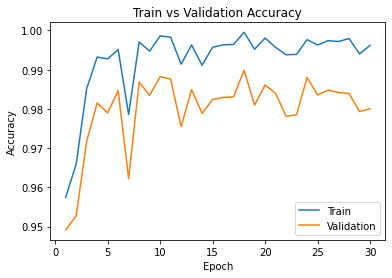

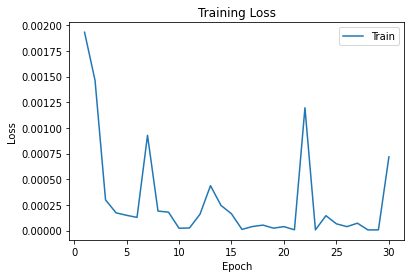

In [ ]:
use_cuda = True

model_ALEX_2 = CNN_feedALEX()

if use_cuda and torch.cuda.is_available():
  model_ALEX_2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_alex(model_ALEX_2, train_feature_dataset, val_feature_dataset, batch_size=128, num_epochs=30, learn_rate=0.001)
model_path = "model_CNN_feedALEX_89_bs128_lr0.001_epoch29"
plot_training_curve(model_path)

In [ ]:
torch.save(model_ALEX_2.state_dict(), '/content/drive/My Drive/Colab Notebooks/Models/V2/model_v2_trained')

In [ ]:
# Load Tensor Files (features) from folder
master_path = '/content/drive/My Drive/Colab Notebooks/fruit360_v3/Alex_features'
#load features
# location on Google Drive

test_feature_dataset = torchvision.datasets.DatasetFolder(master_path + '/' + 'test', loader=torch.load, extensions=('.tensor'))
#test feature loader

batch_size = 32
num_workers = 1
test_feature_loader = torch.utils.data.DataLoader(test_feature_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# Verification Step - obtain one batch of features
dataiter = iter(test_feature_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)

torch.Size([32, 256, 6, 6])
torch.Size([32])


In [ ]:
use_cuda = True
test_feature_loader = torch.utils.data.DataLoader(test_feature_dataset, batch_size=128, 
                                           num_workers=1, shuffle=True)
print("Loader ready")
model_ALEX_2 = CNN_feedALEX()
model_ALEX_2.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/Models/V2/model_v2_trained'))
print("Parameters loaded")

test_accu = get_accuracy(model_ALEX_2, test_feature_loader)
print("Test accuracy is", test_accu)

Loader ready
Parameters loaded
Test accuracy is 0.9807165677772707


CUDA is not available.  Training on CPU ...
Training Started...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
Start getting train accuracy
Start getting val accuracy
Start getting loss
0 0.8577948937384111 0.842941257017664 0.004683977458626032
1 0.8978747682213665 0.879433109680953 0.0023136290255934
2 0.906746541149622 0.8833356155004792 0.0025201630778610706
3 0.916588218513764 0.889702861837601 0.0033064496237784624
4 0.9180430751675938 0.8871011912912502 0.001516681513749063
5 0.9251747254314648 0.8953169930165685 0.006048650946468115
6 0.9434032235059193 0.9092838559496097 0.001352238585241139
7 0.9367850520610469 0.8942900178009038 0.0018638200126588345
8 0.9455141919840251 0.9092838559496097 0.0007900979835540056
9 0.8894879475110541 0.855744214706285 0.0010932961013168097
10 0.9592640136927685 0.9199643981925236 0.0019365184707567096
11 0.9585508486663814 0.9152403122004655 0.001336326589807868
12 0.9335900727428327 0.892989

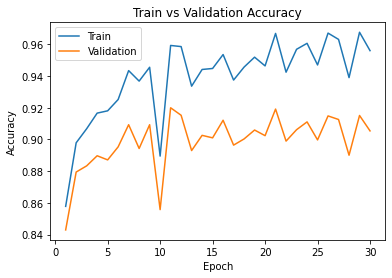

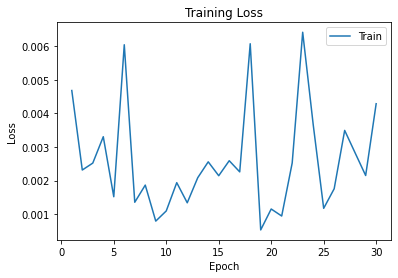

In [ ]:
use_cuda = True

model_ALEX_3 = CNN_feedALEX()

if use_cuda and torch.cuda.is_available():
  model_ALEX_3.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_alex(model_ALEX_3, train_feature_dataset, val_feature_dataset, batch_size=128, num_epochs=30, learn_rate=0.005)
model_path = "model_CNN_feedALEX_89_bs128_lr0.005_epoch29"
plot_training_curve(model_path)

In [ ]:
torch.save(model_ALEX_3.state_dict(), '/content/drive/My Drive/Colab Notebooks/Models/V3/model_v3_trained')

In [ ]:
use_cuda = True
test_feature_loader = torch.utils.data.DataLoader(test_feature_dataset, batch_size=128, 
                                           num_workers=1, shuffle=True)
print("Loader ready")
model_ALEX_3 = CNN_feedALEX()
model_ALEX_3.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/Models/V3/model_v3_trained'))
print("Parameters loaded")

test_accu = get_accuracy(model_ALEX_3, test_feature_loader)
print("Test accuracy is", test_accu)

Loader ready
Parameters loaded
1 accuracy
2 accuracy
3 accuracy
4 accuracy
5 accuracy
6 accuracy
7 accuracy
8 accuracy
9 accuracy
10 accuracy
11 accuracy
12 accuracy
13 accuracy
14 accuracy
15 accuracy
16 accuracy
17 accuracy
18 accuracy
19 accuracy
20 accuracy
21 accuracy
22 accuracy
23 accuracy
24 accuracy
25 accuracy
26 accuracy
27 accuracy
28 accuracy
29 accuracy
30 accuracy
31 accuracy
32 accuracy
33 accuracy
34 accuracy
35 accuracy
36 accuracy
37 accuracy
38 accuracy
39 accuracy
40 accuracy
41 accuracy
42 accuracy
43 accuracy
44 accuracy
45 accuracy
46 accuracy
47 accuracy
48 accuracy
49 accuracy
50 accuracy
51 accuracy
52 accuracy
53 accuracy
54 accuracy
55 accuracy
56 accuracy
57 accuracy
58 accuracy
59 accuracy
60 accuracy
61 accuracy
62 accuracy
63 accuracy
64 accuracy
65 accuracy
66 accuracy
67 accuracy
68 accuracy
69 accuracy
Test accuracy is 0.902555910543131


## Demonstration

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt # for plotting

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
def model_demo (img, model): 
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())
  features_tensor.unsqueeze(0)
  out = model(features_tensor)
  pred = out.max(1, keepdim=True)[1]
  return pred

In [ ]:
torch.manual_seed(1) # set the random seed
class CNN_feedALEX(nn.Module):
      def __init__(self):
          self.name = "CNN_feedALEX_89"
          super(CNN_feedALEX, self).__init__()
          self.conv1 = nn.Conv2d(256, 128, 2) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(5 * 5 * 128, 256)
          self.fc2 = nn.Linear(256, 89)
      def forward(self, x):
          x = F.relu(self.conv1(x))
          x = x.view(-1, 5 * 5 * 128)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

##Demo with Dataset

In [ ]:
master_path = '/content/drive/My Drive/Colab Notebooks/Demo Verification/'
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomRotation(90),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=3, fill=0), 
                                transforms.ToTensor()])
demo_360_dataset = torchvision.datasets.ImageFolder(master_path + 'Demo Fruit 360', transform=transform)
batch_size = 64 
num_workers = 1
demo_360_loader = torch.utils.data.DataLoader(demo_360_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

classes = ['Apple Braeburn', 'Apple Golden 2', 'Apple Granny Smith', 
            'Apple Red 1', 'Apple Red 2', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 
            'Apricot', 'Avocado ripe', 'Banana', 'Banana Red', 'Cactus fruit', 
            'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 
            'Cherry Wax Red', 'Cherry Wax Yellow', 'Clementine', 'Cocos', 'Dates', 'Fig', 
            'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 
            'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Huckleberry', 'Kaki', 'Kumquats', 
            'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Maracuja', 'Melon Piel de Sapo', 
            'Mulberry', 'Nectarine', 'Nut Forest', 'Nut Pecan', 'Papaya', 'Passion Fruit', 'Peach', 
            'Peach 2', 'Peach Flat', 'Pear', 'Pear 2', 'Pear Abate', 'Pear Forelle', 
            'Pear Monster', 'Pear Red', 'Pear Stone', 'Pear Williams', 'Pepino', 'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 
            'Physalis', 'Physalis with Husk', 'Pineapple', 'Pineapple Mini', 'Pitahaya Red', 'Plum 3', 'Pomegranate', 
            'Quince', 'Rambutan', 'Raspberry', 
            'Redcurrant', 'Strawberry', 'Strawberry Wedge', 'Tamarillo', 'Tangelo', 'Tomato 1', 'Tomato 2', 'Tomato 3', 
            'Tomato Cherry Red', 'Tomato Heart', 'Walnut']

(64, 3, 224, 224)


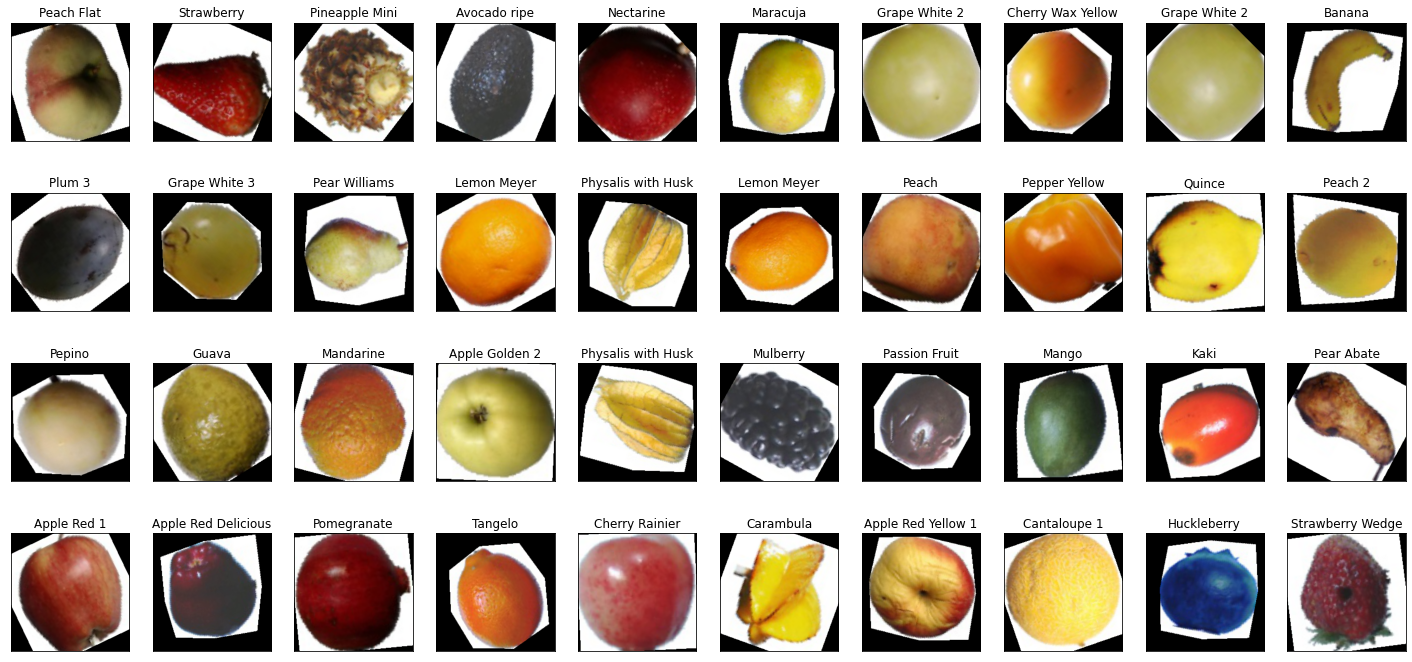

In [ ]:
# obtain one batch of training images
dataiter = iter(demo_360_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print((np.array(images)).shape)
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 12))
for idx in np.arange(40):
    ax = fig.add_subplot(4, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

Actual: Mulberry
Predicted: Mulberry


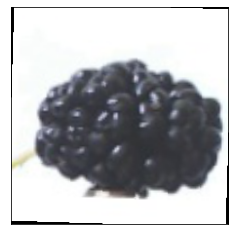

In [ ]:
use_cuda = True

batch_size = 1 
num_workers = 1
demo_360_loader = torch.utils.data.DataLoader(demo_360_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
#print("finish load")
finalModel = CNN_feedALEX()
finalModel.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/Models/V2/model_v2_trained'))
fig = plt.figure(figsize=(10, 4))
for img, label in demo_360_loader:
  #plt.imshow(img)
  pred_label = model_demo (img, finalModel)
  #print(pred_label)
  print("Actual:", classes[label])
  print("Predicted:", classes[pred_label[0][0]])
  image = img.numpy()
  image = image.squeeze(0)
  plt.axes(xticks=[], yticks=[])
  plt.imshow(np.transpose(image, (1, 2, 0)))
  break

In [ ]:
for img, label in demo_360_loader:
  pred_label = model_demo (img, finalModel)
  if classes[label] != classes[pred_label[0][0]]: 
    print("Actual:", classes[label])
    print("Predicted:", classes[pred_label[0][0]])
    print("--------------")

Actual: Apple Red 1
Predicted: Peach
--------------
Actual: Grape Pink
Predicted: Grape Blue
--------------
Actual: Grape Pink
Predicted: Grape Blue
--------------
Actual: Nectarine
Predicted: Apple Red Yellow 1
--------------
Actual: Nut Forest
Predicted: Nectarine
--------------
Actual: Kumquats
Predicted: Apple Red 2
--------------
Actual: Avocado ripe
Predicted: Plum 3
--------------
Actual: Apple Red 1
Predicted: Grape Pink
--------------
Actual: Nut Forest
Predicted: Apple Braeburn
--------------


##Demo with Real

In [ ]:
master_path = '/content/drive/My Drive/Colab Notebooks/Demo Verification/'
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomRotation(90),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=3, fill=0), 
                                transforms.ToTensor()])
demo_dataset = torchvision.datasets.ImageFolder(master_path + 'Fruit Dataset Test', transform=transform)
batch_size = 16
num_workers = 1
demo_loader = torch.utils.data.DataLoader(demo_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

classes_small = ['Banana', 'Grape Pink', 'Tomato 2']


(16, 3, 224, 224)


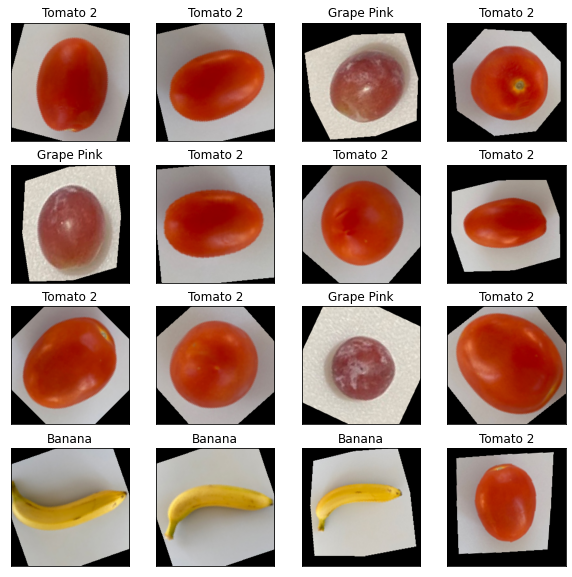

In [ ]:
# obtain one batch of training images
dataiter = iter(demo_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print((np.array(images)).shape)
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 10))
for idx in np.arange(16):
    ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes_small[labels[idx]])

Actual: Tomato 2
Predicted: Tomato 2
----------------------


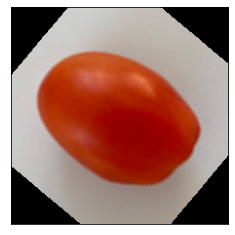

In [ ]:
use_cuda = True
classes = ['Apple Braeburn', 'Apple Golden 2', 'Apple Granny Smith', 
            'Apple Red 1', 'Apple Red 2', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 
            'Apricot', 'Avocado ripe', 'Banana', 'Banana Red', 'Cactus fruit', 
            'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 
            'Cherry Wax Red', 'Cherry Wax Yellow', 'Clementine', 'Cocos', 'Dates', 'Fig', 
            'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 
            'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Huckleberry', 'Kaki', 'Kumquats', 
            'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Maracuja', 'Melon Piel de Sapo', 
            'Mulberry', 'Nectarine', 'Nut Forest', 'Nut Pecan', 'Papaya', 'Passion Fruit', 'Peach', 
            'Peach 2', 'Peach Flat', 'Pear', 'Pear 2', 'Pear Abate', 'Pear Forelle', 
            'Pear Monster', 'Pear Red', 'Pear Stone', 'Pear Williams', 'Pepino', 'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 
            'Physalis', 'Physalis with Husk', 'Pineapple', 'Pineapple Mini', 'Pitahaya Red', 'Plum 3', 'Pomegranate', 
            'Quince', 'Rambutan', 'Raspberry', 
            'Redcurrant', 'Strawberry', 'Strawberry Wedge', 'Tamarillo', 'Tangelo', 'Tomato 1', 'Tomato 2', 'Tomato 3', 
            'Tomato Cherry Red', 'Tomato Heart', 'Walnut']
batch_size = 1 
num_workers = 1
demo_loader = torch.utils.data.DataLoader(demo_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
#print("finish load")
finalModel = CNN_feedALEX()
finalModel.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/Models/V2/model_v2_trained'))
fig = plt.figure(figsize=(10, 4))
for img, label in demo_loader:
  #plt.imshow(img)
  pred_label = model_demo (img, finalModel)
  #print(pred_label)
  print("Actual:", classes_small[label])
  print("Predicted:", classes[pred_label[0][0]])
  image = img.numpy()
  image = image.squeeze(0)
  plt.axes(xticks=[], yticks=[])
  plt.imshow(np.transpose(image, (1, 2, 0)))
  print ("----------------------")
  break

##Analysis

In [ ]:
master_path = '/content/drive/My Drive/Colab Notebooks/Analysis/Folder 3'
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomRotation(90),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=3, fill=0), 
                                transforms.ToTensor()])
analysis_dataset = torchvision.datasets.ImageFolder(master_path, transform=transform)
batch_size = 20 
num_workers = 1
analysis_loader = torch.utils.data.DataLoader(analysis_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

classes_analysis = ['Tomato Cherry Red']

In [ ]:
print(demo_dataset.imgs[0])
print("Break")
print(demo_loader.dataset.imgs)

('/content/drive/My Drive/Colab Notebooks/Demo Verification/Fruit Dataset Test/Avocado ripe/IMG_4822.jpg', 0)
Break
[('/content/drive/My Drive/Colab Notebooks/Demo Verification/Fruit Dataset Test/Avocado ripe/IMG_4822.jpg', 0), ('/content/drive/My Drive/Colab Notebooks/Demo Verification/Fruit Dataset Test/Avocado ripe/IMG_4823.jpg', 0), ('/content/drive/My Drive/Colab Notebooks/Demo Verification/Fruit Dataset Test/Avocado ripe/IMG_4824.jpg', 0), ('/content/drive/My Drive/Colab Notebooks/Demo Verification/Fruit Dataset Test/Avocado ripe/IMG_4825.jpg', 0), ('/content/drive/My Drive/Colab Notebooks/Demo Verification/Fruit Dataset Test/Avocado ripe/IMG_4826.jpg', 0), ('/content/drive/My Drive/Colab Notebooks/Demo Verification/Fruit Dataset Test/Avocado ripe/IMG_4827.jpg', 0), ('/content/drive/My Drive/Colab Notebooks/Demo Verification/Fruit Dataset Test/Banana/IMG_4795.jpg', 1), ('/content/drive/My Drive/Colab Notebooks/Demo Verification/Fruit Dataset Test/Banana/IMG_4796.jpg', 1), ('/cont

Tomato Cherry Red
Tomato Cherry Red
--------------
Tomato Cherry Red
Tomato Cherry Red
--------------
Tomato Cherry Red
Tomato Cherry Red
--------------
Tomato Cherry Red
Tomato Cherry Red
--------------
Tomato Cherry Red
Tomato Cherry Red
--------------
Tomato Cherry Red
Tomato Cherry Red
--------------
Tomato Cherry Red
Tomato Cherry Red
--------------
Tomato Cherry Red
Tomato Cherry Red
--------------
Tomato Cherry Red
Tomato Cherry Red
--------------
Tomato Cherry Red
Tomato Cherry Red
--------------
Tomato Cherry Red
Tomato Cherry Red
--------------
Tomato Cherry Red
Tomato Cherry Red
--------------
Tomato Cherry Red
Tomato Cherry Red
--------------
Tomato Cherry Red
Tomato Cherry Red
--------------
Tomato Cherry Red
Tomato Cherry Red
--------------
Tomato Cherry Red
Tomato Cherry Red
--------------
Tomato Cherry Red
Tomato Cherry Red
--------------
Tomato Cherry Red
Tomato Cherry Red
--------------
Tomato Cherry Red
Tomato Cherry Red
--------------
Tomato Cherry Red
Tomato Cherry

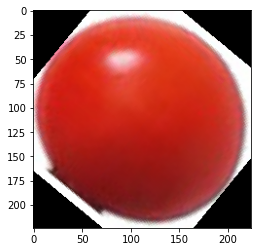

In [ ]:
use_cuda = True
classes = ['Apple Braeburn', 'Apple Golden 2', 'Apple Granny Smith', 
            'Apple Red 1', 'Apple Red 2', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 
            'Apricot', 'Avocado ripe', 'Banana', 'Banana Red', 'Cactus fruit', 
            'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 
            'Cherry Wax Red', 'Cherry Wax Yellow', 'Clementine', 'Cocos', 'Dates', 'Fig', 
            'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 
            'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Huckleberry', 'Kaki', 'Kumquats', 
            'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Maracuja', 'Melon Piel de Sapo', 
            'Mulberry', 'Nectarine', 'Nut Forest', 'Nut Pecan', 'Papaya', 'Passion Fruit', 'Peach', 
            'Peach 2', 'Peach Flat', 'Pear', 'Pear 2', 'Pear Abate', 'Pear Forelle', 
            'Pear Monster', 'Pear Red', 'Pear Stone', 'Pear Williams', 'Pepino', 'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 
            'Physalis', 'Physalis with Husk', 'Pineapple', 'Pineapple Mini', 'Pitahaya Red', 'Plum 3', 'Pomegranate', 
            'Quince', 'Rambutan', 'Raspberry', 
            'Redcurrant', 'Strawberry', 'Strawberry Wedge', 'Tamarillo', 'Tangelo', 'Tomato 1', 'Tomato 2', 'Tomato 3', 
            'Tomato Cherry Red', 'Tomato Heart', 'Walnut']
batch_size = 1 
num_workers = 1
analysis_loader = torch.utils.data.DataLoader(analysis_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
#print("finish load")
finalModel = CNN_feedALEX()
finalModel.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/Models/V2/model_v2_trained'))
fig = plt.figure(figsize=(10, 4))
for img, label in analysis_loader:
  #plt.imshow(img)
  pred_label = model_demo (img, finalModel)
  #print(pred_label)
  print(classes_analysis[label])
  #print(pred_label[0])
  print(classes[pred_label[0][0]])
  image = img.numpy()
  image = image.squeeze(0)
  plt.imshow(np.transpose(image, (1, 2, 0)))
  print("--------------")
  #break

In [ ]:
for item in classes:
  print("mkdir \"{0}\"".format(item))